# Collect and Plotting Statistics

This tutorial explains how to collect and plot runtime statistics in two ways:

* [The Manual Approach](#The-Manual-Approach): Collecting fitness values directly from individuals.

* [Automating with Watcher](#Automating-with-Watcher): Collecting and reporting fitness values using the `evokit.watch` module.

In [1]:
import matplotlib.pyplot as plt
import random
random.seed(1)

## Construct an Algorithm

For convenience, this tutorial uses a pre-built algorithm that uses the following components.

| Component  | Choice               |
| ---------- | -------------------- |
| Individual | Binary string        |
| Evaluator  | OneMax               |
| Selector   | Elitist truncation   |
| Variator   | Mutation ($p=0.2$)   |

To mimic the size of a practical problem, let's use the following hyperparameters. All choices are defined as constants in the following cell; please adjust them as you see fit.

| Parameter       | Choice |
| --------------- | ------ |
| Population size | 1000   |
| Individual size | 10000  |
| Epochs          | 30     |

In [2]:
MUTATION_P: float = 0.2
STEP_COUNT: int = 30
POP_SIZE: int = 1000
IND_SIZE: int = 10000

from evokit.evolvables.prefabs import make_onemax

## The Manual Approach

Let's begin with collecting and plotting fitness values by hand. Recall (from the [Algorithm tutorial](./algorithm.ipynb)) how everything falls into place:

* The algorithm returned by `make_onemax` is an instance of `HomogenousAlgorithm`, which means it has one `.population`.

* The `.population` is an instance of `Population`, which means it is a collection of individuals.

* Each individual is an instance of `BitString`, a subclass of `Individual`. All subclasses of `Individual` inherits the `.fitness` attribute.

We want to plot the fitness value of the individual with the highest `.population`. `Population.best(...)` conveniently returns one such individual; we need only collect and plot its `.fitness`.

In [3]:
best_fitnesses: list[float] = []

algo = make_onemax(POP_SIZE,
                   IND_SIZE,
                   MUTATION_P,
                   max_parents=0)

for _ in range(STEP_COUNT):
    algo.step()
    best_fitnesses.append(algo.population.best().fitness[0])


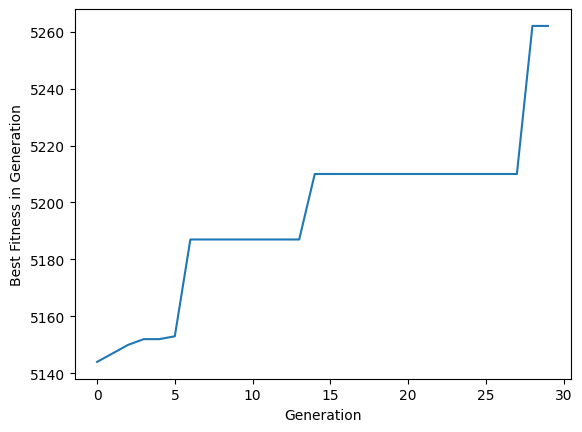

In [4]:
plt.plot(range(STEP_COUNT), best_fitnesses)
plt.xlabel("Generation")
plt.ylabel("Best Fitness in Generation")
plt.show()

## Automating with Watcher

The `evokit.watch` module can help collect and report runtime statistics. Compared to the manual, a `watch.Watcher` can run as soon as events happen, work with a wide range of algorithms, and report data in a easily comparable format.

Components of the module fall into into three categories:

1. The `Watcher` class, which can both
    
    a. be called to create simple watchers with custom handlers and
    
    b. serve as a base class for more complex watchers.

2. The `.visualier` submodule, which contains tools for plotting collected records.

3. Stock watchers that collect, for example, cpu and memory usage.

This tutorial mainly discusses #1.a and #2.

### Inspecting Available Events

The `watch` module performs its function with the `Watcher` class. A `Watcher` can be attached to an `Algorithm` and respond to certain events fired by the algorithm. Please see the [Algorithm tutorial](./algorithm.ipynb) for how an algorithm fires events.

From the user's perspective, an algorithm can only fire events it declares in `.events` and `.automatic_events`. Let's check these!

In [5]:
algo_2 = make_onemax(POP_SIZE,
                     IND_SIZE,
                     MUTATION_P,
                     max_parents=0)

print(f"events: {algo_2.events};"
      f" automatic events: {algo_2.automatic_events}")

events: ['POST_VARIATION', 'POST_EVALUATION', 'POST_SELECTION']; automatic events: ('POST_STEP',)


These attributes correspond to two sorts of events:

* `.events` contain manual events. These events can be fired by calling `.update` (typically from inside `.step(...)`).

* `.automatic_events` are fired regardless of how the algorithm is coded. For example, `POST_STEP` fires after `.step(...)` is called but before control returns to the caller.


### Crafting an Watcher

An watcher must be created with `accounting.Watcher`. The constructor can take five parameters:

1. A list of `events` that can trigger collection.

2. A callable `handler` that collects data from the associated algorithm

3. An optional `stride` that can space out collections

4. An optional, position-only `watch_post_step` that decides if the watcher triggers on `STEP_END`. The last parameter is there for convenience: setting `watch_post_step` to `True` has the same effect as adding `STEP_END` to `events`.

5. An optional, keyword-only `timer`. The default `time.process_time`, while useful for HPC tasks, records the CPU time, which can be much shorter than the actual run time. Let's use `time.perf_counter` to drag things out a little.

Let's declare an `Watcher` that collects the best fitness from a population only after a step ends. As the type hint shows, the watcher collects...

* ... from a `SimpleLinearAlgorithm` of `BitString`s,

* a fitness value of type `float`.

In [6]:
from evokit.watch import Watcher
from evokit.evolvables.algorithms import SimpleLinearAlgorithm
from evokit.evolvables.bitstring import BitString
import time

fit_acc = Watcher[SimpleLinearAlgorithm[BitString], float](
    events=SimpleLinearAlgorithm.events,
    handler=lambda algo: algo.population.best().fitness[0],
    watch_post_step=True,
    timer=time.process_time)

### Registering a Watcher

Once constructed, the watcher can be registered with an algorithm by calling `Algorithm.register(...)`.

Internally, `Algorithm.register(...)` calls `Watcher.subscribe(...)` so that the algorithm and the watcher reference each other [^1]. The following figure illustrates this:

<img src='./media/ec-watch-init.svg' style='width: 25em'></img>


In [7]:
algo_2.register(fit_acc)

assert fit_acc in algo_2.watchers
assert algo_2 is fit_acc.subject

### Collecting Statistics

Now that everything is in place, let's run the algorithm and see what happens!

When an event fires in the Algorithm, it calls `Algorithm.update` which calls `Watcher.update` for each watcher in the algorithm's `.watchers`. Then, the watcher collects statistics from its `.subject` only if either (a) the event is in its `.events` or (b) the watcher's `.watch_post_step` is `True` and the event is `POST_STEP`.

<img src='./media/ec-watch-update.svg' style='width: 19em'></img>

Because `POST_STEP` triggers only at the end of each `.step(...)`, it's good practice to fire it at the beginning so that we know how things started. Here goes:

In [8]:
algo_2.update("POST_STEP")
for _ in range(STEP_COUNT):
    algo_2.step()

To inspect what data the watcher has collected, call `Watcher.report(...)`. Note that records collected immediately after `POST_VARIATION` have `value=nan`. This is because the variator resets the fitness values of all.

In [9]:
fit_acc.report()[:4]

[WatcherRecord(event='POST_STEP', generation=0, value=nan, time=0.6875),
 WatcherRecord(event='POST_VARIATION', generation=0, value=nan, time=0.6875),
 WatcherRecord(event='POST_EVALUATION', generation=0, value=5180, time=0.6875),
 WatcherRecord(event='POST_SELECTION', generation=0, value=5180, time=0.703125)]

### Plotting

The `watch.visual` module has tools to plot data from a `Watcher`. Give it a try! Note that data points are plotted against time. This should make it easier to compare performance.

For simplicity, only end-of-generation fitness values are plotted here. The next section will be much more interesting.

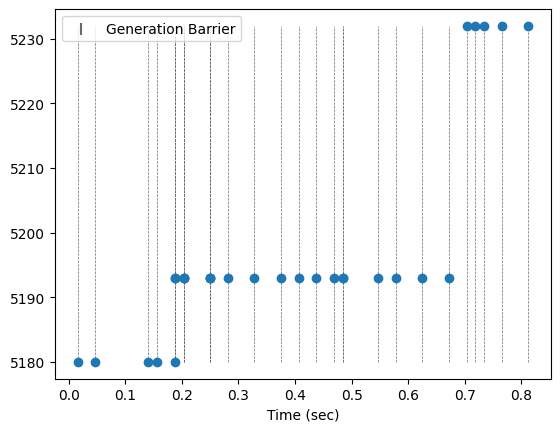

In [ ]:
from evokit.watch.visual import plot

plot([x for x in fit_acc.report() if x.event == "POST_STEP"],
     show_generation=True,)

Now the fun begins. Recall that this experiment uses a rather ambitious mutation rate and an elitist selector. The high mutation rate increases the possibility that offspring have a lower best fitness than the parents, but the elitist selector ensures that the best parent is always retained, preventing a generational decline in fitness.

The following cell plots three figures to reflect this:

* The first figure shows what could be collected with the manual approach. As we only have access to the population outside of `.step(...)`, there is not much chance to observe how an elitist selector operates.

* The second figure plots all observed fitnesses. Here, each "hockey stick" shows where the elitist selector updates the population with the best parent.

* The third figure, using `watch.visual.plot`, plots all data points against time. We see that generations often take different amounts of time, and that the elitist mechanism takes less time to run than what plot 2 suggests, 

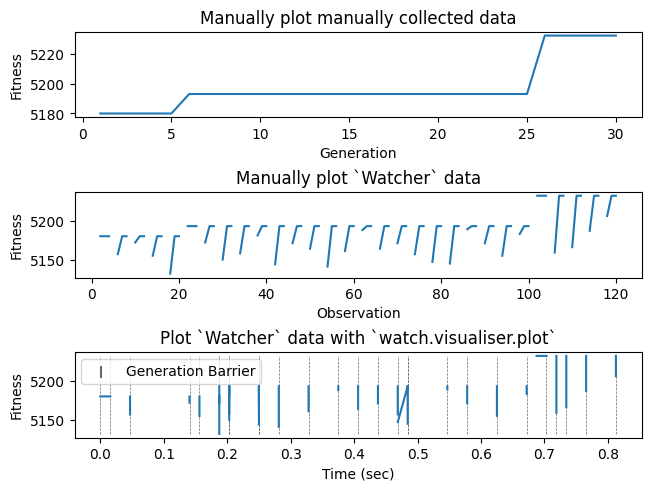

In [ ]:
_, (ax1, ax2, ax3) = plt.subplots(nrows=3,
                                  ncols=1,
                                  layout='constrained')

ax3.set_title("Plot `Watcher` data with `watch.visualiser.plot`")
plot(fit_acc.report(),
     show_generation=True,
     axes=ax3,
     use_line=True)
ax3.set_ylabel("Fitness")


ax2.set_title("Manually plot `Watcher` data")
_data = [x.value for x in fit_acc.report()]
ax2.plot(range(len(_data)), _data)
ax2.set_xlabel("Observation")
ax2.set_ylabel("Fitness")


ax1.set_title("Manually plot manually collected data")
_data = [x.value for x in fit_acc.report() if x.event == "POST_STEP"]
ax1.plot(range(len(_data)), _data)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

plt.show()